In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.utils import resample

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def balance_data(x,y):

    minor_index = int(y.mean()>0.5)
    minor_x = x[y==minor_index]
    major_x = x[y!=minor_index]

    minor_upsample = resample(minor_x,
                 replace=True,
                 n_samples=len(major_x),
                 random_state=42)
    upsampled_x = pd.concat([major_x, minor_upsample])
    upsampled_y = np.array(len(major_x)*[1-minor_index]+len(minor_upsample)*[minor_index])
    upsampled_x,upsampled_y = shuffle(upsampled_x,upsampled_y)
    return upsampled_x,upsampled_y

In [2]:
df_base = pd.read_csv('sofa_parameters.csv').reset_index(names=['id'])

cols2 = [
    'id',
    'insurance',
    'marital_status',
    'race',
    'gender',
    'admission_age',
    'weight',
    'height',
    'charlson_comorbidity_index',
    'x30d_mortality_status']
resp= ['respiration_SOFA_d1',
    'respiration_SOFA_d3',
    'respiration_SOFA_d5',
    'respiration_SOFA_d7',
    'respiration_SOFA_d9',
    'respiration_SOFA_d11',
    'respiration_SOFA_d13']
coag =['coagulation_SOFA_d1',
    'coagulation_SOFA_d3',
    'coagulation_SOFA_d5',
    'coagulation_SOFA_d7',
    'coagulation_SOFA_d9',
    'coagulation_SOFA_d11',
    'coagulation_SOFA_d13']
liver= ['liver_SOFA_d1',
    'liver_SOFA_d3',
    'liver_SOFA_d5',
    'liver_SOFA_d7',
    'liver_SOFA_d9',
    'liver_SOFA_d11',
    'liver_SOFA_d13']
card=['cardiovascular_SOFA_d1',
    'cardiovascular_SOFA_d3',
    'cardiovascular_SOFA_d5',
    'cardiovascular_SOFA_d7',
    'cardiovascular_SOFA_d9',
    'cardiovascular_SOFA_d11',
    'cardiovascular_SOFA_d13']
cns=['cns_SOFA_d1',
    'cns_SOFA_d3',
    'cns_SOFA_d5',
    'cns_SOFA_d7',
    'cns_SOFA_d9',
    'cns_SOFA_d11',
    'cns_SOFA_d13']
renal=['renal_SOFA_d1',
    'renal_SOFA_d3',
    'renal_SOFA_d5',
    'renal_SOFA_d7',
    'renal_SOFA_d9',
    'renal_SOFA_d11',
    'renal_SOFA_d13']
sofa_ds = [
    'SOFA_d1',
    'SOFA_d3',
    'SOFA_d5',
    'SOFA_d7',
    'SOFA_d9',
    'SOFA_d11',
    'SOFA_d13']
delta=['delta1_3',
    'delta3_5',
    'delta5_7',
    'delta7_9',
    'delta9_11',
    'delta11_13']
auc=['Area1_3',
    'Area3_5',
    'Area5_7',
    'Area7_9',
    'Area9_11',
    'Area11_13']

for val, val_1 in enumerate(delta):
    df_base[delta[val]] = df_base[sofa_ds[val+1]]-df_base[sofa_ds[val]]
    df_base[auc[val]] = (df_base[sofa_ds[val+1]]-df_base[sofa_ds[val]])/2

accs = {}
baccs = {}
f1s = {}
prs = {}
recs = {}
rocs = {}
cms = {}
v_accs = {}
v_baccs = {}
v_f1s = {}
v_prs = {}
v_recs = {}
v_rocs = {}
v_cms = {}

In [3]:
df_validation = pd.read_csv('SEPSIS.csv').reset_index(names=['id'])

In [4]:
count = -1
for n in [1,3]:
    count = count + 1
    sofa_cols = sofa_ds[0:n+1]
    param_list =[*resp[0:n+1], *coag[0:n+1], *liver[0:n+1], *card[0:n+1], *cns[0:n+1],
                 *renal[0:n+1], *sofa_cols, *delta[0:n], *auc[0:n]]
    
    df_dofas = df_base[['id',*sofa_cols]].copy()
    df_dofas = df_dofas.dropna(how='all', subset = sofa_cols) 

    df_dofas_v = df_validation[['id',*sofa_cols]].copy()
    df_dofas_v = df_dofas_v.dropna(how='all', subset = sofa_cols) 
    
    df = df_base[[
        'id',*cols2,*param_list
    ]].copy()
    
    df_v = df_validation[[
        'id',*cols2,*param_list
    ]].copy()    

    df.loc[:,'TotalAUC'] = df[auc[0:n]].sum(axis=1)
    df.loc[:,'SOFA_max'] = df_dofas[sofa_cols].max(axis=1)
    df.loc[:,'SOFA_min'] = df_dofas[sofa_cols].min(axis=1)
    def f(x):
        if pd.isna(x): return np.nan
        return int(x.replace('SOFA_d',''))
    df.loc[:,'SOFA_max_day'] = df_dofas[sofa_cols].idxmax(axis=1,skipna=True).apply(lambda x: f(x))
    df.loc[:,'SOFA_min_day'] = df_dofas[sofa_cols].idxmin(axis=1,skipna=True).apply(lambda x: f(x))    
    df.loc[:,'SOFA_range'] = df['SOFA_max_day']-df['SOFA_min_day']
    df.loc[:,'SOFA_long_stay'] = (~df_dofas[sofa_cols].isna()).sum(axis=1)

    df_v.loc[:,'TotalAUC'] = df_v[auc[0:n]].sum(axis=1)
    df_v.loc[:,'SOFA_max'] = df_dofas_v[sofa_cols].max(axis=1)
    df_v.loc[:,'SOFA_min'] = df_dofas_v[sofa_cols].min(axis=1)
    df_v.loc[:,'SOFA_max_day'] = df_dofas_v[sofa_cols].idxmax(axis=1,skipna=True).apply(lambda x: f(x))
    df_v.loc[:,'SOFA_min_day'] = df_dofas_v[sofa_cols].idxmin(axis=1,skipna=True).apply(lambda x: f(x))    
    df_v.loc[:,'SOFA_range'] = df_v['SOFA_max_day']-df_v['SOFA_min_day']
    df_v.loc[:,'SOFA_long_stay'] = (~df_dofas_v[sofa_cols].isna()).sum(axis=1)
    
    df = df.fillna(0).reset_index()
    df_v = df_v.fillna(0).reset_index()
    
    le = {}
    for k in ['insurance','marital_status','race','gender']:
        le[k] = LabelEncoder()
        df[k] = le[k].fit_transform(df[k].astype(str))
        df_v[k] = le[k].fit_transform(df_v[k].astype(str))
    
    x = df.drop(columns=['id','id','index','x30d_mortality_status'])
    y = df['x30d_mortality_status']

    x_v = df_v.drop(columns=['id','id','index','x30d_mortality_status'])
    y_v = df_v['x30d_mortality_status']
    
    feat_set = list(x.columns)
    feat_dic = {j:i for i,j in enumerate(feat_set)}
    
    kf = KFold(n_splits=5)
    
    feat_list = []
    feature_importances_list = []
    accs[count] = []
    accs_eff = []
    baccs[count] = []
    f1s[count] = []
    prs[count] = []
    recs[count] = []
    rocs[count] = []
    cms[count] = []
    v_accs[count] = []
    v_accs_eff = []
    v_baccs[count] = []
    v_f1s[count] = []
    v_prs[count] = []
    v_recs[count] = []
    v_rocs[count] = []
    v_cms[count] = []
    
    for i_try in range(5):
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            x_train,y_train = balance_data(x_train,y_train)
            
            clf = RandomForestClassifier()
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            
            y_valid = clf.predict(x_v)
            
            acc = accuracy_score(y_test,y_pred)
            bacc = balanced_accuracy_score(y_test,y_pred)
            f1 = f1_score(y_test,y_pred)
            pr = precision_score(y_test,y_pred)
            rec = recall_score(y_test,y_pred)
            roc = roc_auc_score(y_test,y_pred)
            cm = confusion_matrix(y_test, y_pred, labels=[0,1])

            v_acc = accuracy_score(y_v,y_valid)
            v_bacc = balanced_accuracy_score(y_v,y_valid)
            v_f1 = f1_score(y_v,y_valid)
            v_pr = precision_score(y_v,y_valid)
            v_rec = recall_score(y_v,y_valid)
            v_roc = roc_auc_score(y_v,y_valid)
            v_cm = confusion_matrix(y_v, y_valid, labels=[0,1])
            
            accs[count].append(acc)
            accs_eff.append(acc)
            baccs[count].append(bacc)
            f1s[count].append(f1)
            prs[count].append(pr)
            recs[count].append(rec)
            rocs[count].append(roc)
            cms[count].append(cm)
            
            feat_list.extend(feat_set)
            feature_importances_list.append(clf.feature_importances_)
            accs_eff.append(clf.score(x_test,y_test))
            
            v_accs[count].append(v_acc)
            v_accs_eff.append(v_acc)
            v_baccs[count].append(v_bacc)
            v_f1s[count].append(v_f1)
            v_prs[count].append(v_pr)
            v_recs[count].append(v_rec)
            v_rocs[count].append(v_roc)
            v_cms[count].append(v_cm)
            v_accs_eff.append(clf.score(x_v, y_v))
            
    pos = f1s[count].index(max(f1s[count]))

    v_accs[count]=v_accs[count][pos]
    v_baccs[count]=v_baccs[count][pos]
    v_f1s[count]=v_f1s[count][pos]
    v_prs[count]=v_prs[count][pos]
    v_recs[count]=v_recs[count][pos]
    v_rocs[count]=v_rocs[count][pos]
    v_cms[count]=v_cms[count][pos]

# Spider plot

In [5]:
metrics = []
set_list = ['3 days MIMIC','3 days PSH','8 days MIMIC','8 days PSH']
for k in range(2):
    #kk = np.stack([accs[k],baccs[k],f1s[k],prs[k],recs[k],rocs[k]],axis=0)
    cm3 = np.array(cms[k])
    tn = cm3[:,0,0]
    fp = cm3[:,0,1]
    fn = cm3[:,1,0]
    tp = cm3[:,1,1]
    npv = tn/(fn+tn)
    spec = 2*np.array(baccs[k]) - np.array(recs[k])
    kk = np.mean(np.stack([recs[k],2*np.array(prs[k]),recs[k],recs[k],rocs[k]],axis=0),axis=1)
    metrics.append(kk)
    cm3 = np.array(v_cms[k])
    tn = cm3[0,0]
    fp = cm3[0,1]
    fn = cm3[1,0]
    tp = cm3[1,1]
    npv = tn/(fn+tn)
    spec = 2*np.array(v_baccs[k]) - np.array(v_recs[k])
    kk = np.stack([v_recs[k],2*np.array(v_prs[k]),spec,npv,v_rocs[k]],axis=0)
    metrics.append(kk)
#metrics = np.mean(np.stack(metrics,axis=0),axis=2)
#metrics.shape

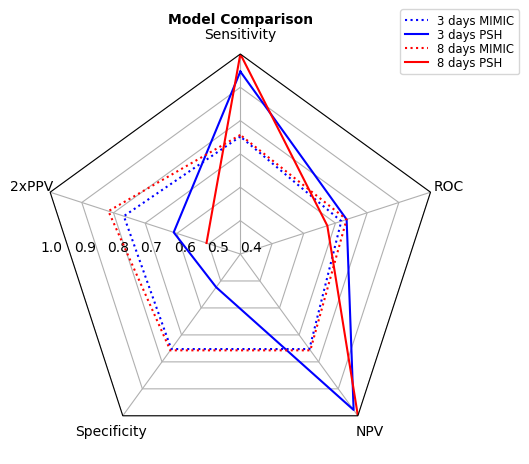

In [6]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

# Precision = PPV
# Recall = Sensitivity
spoke_labels = ['Sensitivity','2xPPV',  'Specificity', 'NPV','ROC']
pd.DataFrame(data = metrics, columns=spoke_labels, index= set_list).to_csv('spider_results.csv')
theta = radar_factory(len(spoke_labels), frame='polygon')

fig, ax = plt.subplots(figsize=(9, 5), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

#colors = ['b', 'r', 'g', 'm', 'y','k']
colors = ['b', 'b', 'r','r']
linestyles = ['dotted','solid','dotted','solid']
# Plot the four cases from the example data on separate axes

title = 'Model Comparison'
case_data = metrics

ax.set_rgrids([0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1], angle=90)
ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
for d, color,linestyle in zip(case_data, colors,linestyles):
    ax.plot(theta, d, color=color, linestyle=linestyle)
    #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)
ax.set_ylim([0.4,1])

# add legend relative to top-left plot
labels = set_list
legend = ax.legend(labels, loc=(0.9, .95),
                          labelspacing=0.1, fontsize='small')
plt.savefig('run2/spider_8.tif',dpi=300)

# Feature Validation Day 1-3

In [7]:
n = 1

sofa_cols = sofa_ds[0:n+1]
param_list =[*sofa_cols, *delta[0:n], *auc[0:n]]

df_dofas = df_validation[['id',*sofa_cols]].copy()
df_dofas = df_dofas.dropna(how='all', subset = sofa_cols) 

df = df_validation[[
    'id',*cols2,*param_list
]].copy()

df.loc[:,'TotalAUC'] = df[auc[0:n]].sum(axis=1)
df.loc[:,'SOFA_max'] = df_dofas[sofa_cols].max(axis=1)
df.loc[:,'SOFA_min'] = df_dofas[sofa_cols].min(axis=1)
def f(x):
    if pd.isna(x): return np.nan
    return int(x.replace('SOFA_d',''))
df.loc[:,'SOFA_max_day'] = df_dofas[sofa_cols].idxmax(axis=1,skipna=True).apply(lambda x: f(x))
df.loc[:,'SOFA_min_day'] = df_dofas[sofa_cols].idxmin(axis=1,skipna=True).apply(lambda x: f(x))    
df.loc[:,'SOFA_range'] = df['SOFA_max_day']-df['SOFA_min_day']
df.loc[:,'SOFA_long_stay'] = (~df_dofas[sofa_cols].isna()).sum(axis=1)

df = df.fillna(0).reset_index()

le = {}
for k in ['insurance','marital_status','race','gender']:
    le[k] = LabelEncoder()
    df[k] = le[k].fit_transform(df[k].astype(str))

x = df.drop(columns=['id','id','index','x30d_mortality_status'])
y = df['x30d_mortality_status']

feat_set = list(x.columns)
feat_dic = {j:i for i,j in enumerate(feat_set)}

kf = KFold(n_splits=5)

feat_list_valid = []
feature_importances_list_valid = []

for i_try in range(5):
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        x_train,y_train = balance_data(x_train,y_train)
        
        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
            
        feat_list_valid.extend(feat_set)
        feature_importances_list_valid.append(clf.feature_importances_)
        
pos = f1s[count].index(max(f1s[count]))


In [8]:
n =1 
sofa_cols = sofa_ds[0:n+1]
param_list =[*sofa_cols, *delta[0:n], *auc[0:n]]

df_dofas = df_base[['id',*sofa_cols]].copy()
df_dofas = df_dofas.dropna(how='all', subset = sofa_cols) 

df = df_base[[
    'id',*cols2,*param_list
]].copy()

df.loc[:,'TotalAUC'] = df[auc[0:n]].sum(axis=1)
df.loc[:,'SOFA_max'] = df_dofas[sofa_cols].max(axis=1)
df.loc[:,'SOFA_min'] = df_dofas[sofa_cols].min(axis=1)
def f(x):
    if pd.isna(x): return np.nan
    return int(x.replace('SOFA_d',''))
df.loc[:,'SOFA_max_day'] = df_dofas[sofa_cols].idxmax(axis=1,skipna=True).apply(lambda x: f(x))
df.loc[:,'SOFA_min_day'] = df_dofas[sofa_cols].idxmin(axis=1,skipna=True).apply(lambda x: f(x))    
df.loc[:,'SOFA_range'] = df['SOFA_max_day']-df['SOFA_min_day']
df.loc[:,'SOFA_long_stay'] = (~df_dofas[sofa_cols].isna()).sum(axis=1)

df = df.fillna(0).reset_index()

le = {}
for k in ['insurance','marital_status','race','gender']:
    le[k] = LabelEncoder()
    df[k] = le[k].fit_transform(df[k].astype(str))

x = df.drop(columns=['id','id','index','x30d_mortality_status'])
y = df['x30d_mortality_status']

feat_set = list(x.columns)
feat_dic = {j:i for i,j in enumerate(feat_set)}

kf = KFold(n_splits=5)

feat_list = []
feature_importances_list = []

for i_try in range(5):
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        x_train,y_train = balance_data(x_train,y_train)
        
        clf = RandomForestClassifier()
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        feat_list.extend(feat_set)
        feature_importances_list.append(clf.feature_importances_)
        accs_eff.append(clf.score(x_test,y_test))

        
pos = f1s[count].index(max(f1s[count]))

''

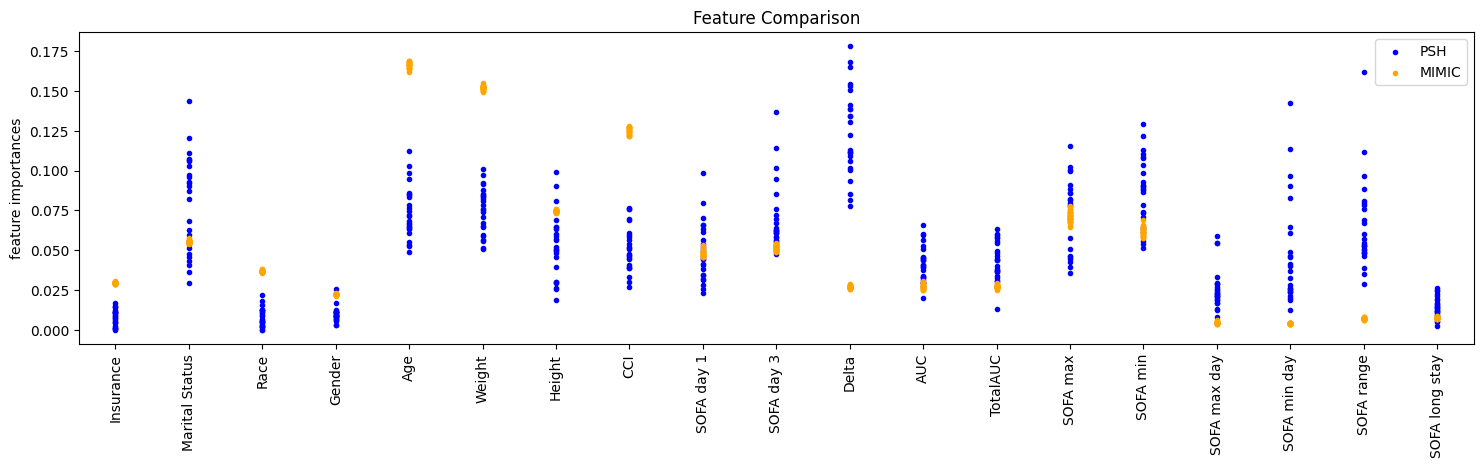

In [9]:
feat_x = [feat_dic[i] for i in feat_list]

tick_list=['Insurance','Marital Status','Race','Gender','Age','Weight','Height','CCI','SOFA day 1','SOFA day 3', 'Delta',
           'AUC','TotalAUC','SOFA max','SOFA min','SOFA max day','SOFA min day','SOFA range','SOFA long stay']

fig,ax = plt.subplots(1,1,figsize=(18,6))
ax.scatter(feat_x,feature_importances_list_valid,marker='.',c='blue')
ax.scatter(feat_x,feature_importances_list,marker='.',c='orange')
ax.set_ylabel('feature importances')
ax.set_xticks(np.arange(len(feat_set)))
ax.set_xticklabels(tick_list, rotation=90)
ax.set_xlim(-0.5,len(feat_set)-0.5)
ax.legend(['PSH', 'MIMIC'])
title = 'Feature Comparison'

ax.set_title(title)
plt.subplots_adjust(bottom=0.36)
plt.savefig('run2/feat_comp{}.tif'.format(n),dpi=300)
plt.savefig('run2/feat_comp{}.jpg'.format(n),dpi=300)
;